In [4]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9e02954babba39d0e4e088d629692dc53f0c1feb50c0d3d75377c3b3fb28737e
  Stored in directory: /home/akansh_26/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=7ed61d30688eb67f1508468c86b845f3265002746b4344e0fb6eb9d2a65f3973
  Stored in directory: /home/akansh_26/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6znytxxu
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6znytxxu
  Resolved https://github.com/albumentations-te

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [5]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 2.81 MiB/s, done.


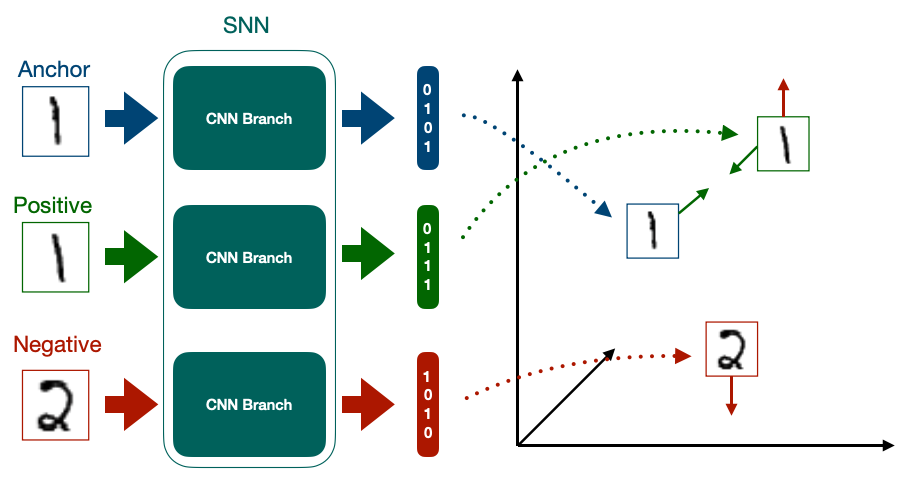

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [2]:
DATA_DIR = "/home/akansh_26/Hackathons/VisionX-AI/Person-Re-Id-Dataset/train"
CSV_FILE = "/home/akansh_26/Hackathons/VisionX-AI/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda"

In [8]:
df = pd.read_csv(CSV_FILE)
df

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg
...,...,...,...
3995,0326_c2s3_074602_01.jpg,1336_c6s3_070592_01.jpg,0326_c6s4_007552_02.jpg
3996,0566_c3s2_004562_03.jpg,0952_c5s2_120574_02.jpg,0566_c3s2_004637_02.jpg
3997,0566_c3s2_013637_01.jpg,0197_c3s1_044551_02.jpg,0566_c3s2_004637_02.jpg
3998,0566_c6s2_007768_03.jpg,0674_c3s2_044987_01.jpg,0566_c3s2_004637_02.jpg


In [9]:
row = df.iloc[14]

A_img = io.imread(DATA_DIR + "/" + row["Anchor"])
P_img = io.imread(DATA_DIR + "/" + row["Positive"])
N_img = io.imread(DATA_DIR + "/" + row["Negative"])

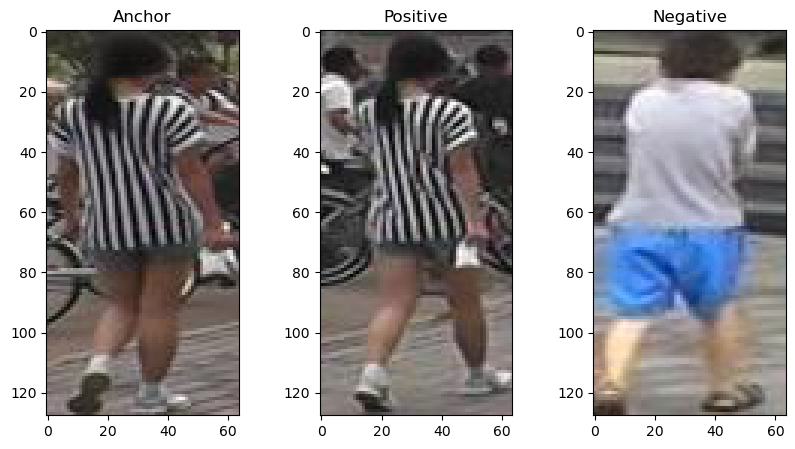

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset

In [12]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + "/" + row["Anchor"])
    P_img = io.imread(DATA_DIR + "/" + row["Positive"])
    N_img = io.imread(DATA_DIR + "/" + row["Negative"])

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


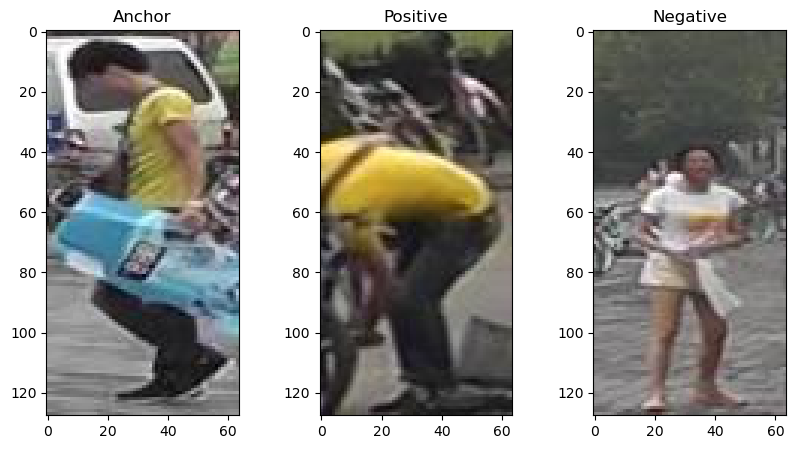

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [3]:
class APN_Model(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)
    return embeddings

In [4]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [19]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    optimizer.zero_grad()

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [20]:
def eval_fn(model, dataloader, criterion):

  model.eval() # ON Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [34]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [35]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 1 train_loss : 0.7103079876303673 valid_loss : 0.4894201159477234


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 2 train_loss : 0.277322041541338 valid_loss : 0.41059257864952087


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 3 train_loss : 0.19389709770679475 valid_loss : 0.2762397676706314


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 4 train_loss : 0.10952992759644985 valid_loss : 0.23498551785945893


100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 5 train_loss : 0.08699732005596161 valid_loss : 0.1960863411426544


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 6 train_loss : 0.07380022034049034 valid_loss : 0.15385114401578903


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


EPOCHS : 7 train_loss : 0.05773247867822647 valid_loss : 0.1808303999900818


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


EPOCHS : 8 train_loss : 0.05076680660247803 valid_loss : 0.1613008451461792


100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


EPOCHS : 9 train_loss : 0.0548810338973999 valid_loss : 0.21612045109272005


100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


EPOCHS : 10 train_loss : 0.09386755496263505 valid_loss : 0.2012229108810425


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


EPOCHS : 11 train_loss : 0.09163206100463867 valid_loss : 0.28815176963806155


100%|██████████| 25/25 [00:04<00:00,  5.02it/s]


EPOCHS : 12 train_loss : 0.10711282633244991 valid_loss : 0.21611273407936096


100%|██████████| 25/25 [00:04<00:00,  5.88it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS : 13 train_loss : 0.03392982304096222 valid_loss : 0.1111748218536377


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


EPOCHS : 14 train_loss : 0.019957569390535355 valid_loss : 0.1509270763397217


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]

EPOCHS : 15 train_loss : 0.021939456313848495 valid_loss : 0.1320684003829956


# Get Anchor Embeddings

In [21]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + "/" + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

<All keys matched successfully>

In [25]:
# df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.030583,0.145966,0.378101,0.209250,-0.083715,-0.404291,0.036114,0.312116,-0.486999,...,0.614557,-0.080048,0.065632,0.535377,0.277494,0.590656,1.093547,0.588941,0.294551,-0.198625
1,1420_c3s3_061978_03.jpg,0.028648,0.085002,0.351765,0.211520,-0.140734,-0.645334,-0.043826,0.423686,-0.360870,...,0.412704,-0.206530,-0.009991,0.472302,0.346313,0.714154,1.182768,0.536564,0.211620,-0.162530
2,1420_c5s3_062565_05.jpg,0.060686,0.173928,0.315575,0.282380,-0.234788,-0.493188,-0.028236,0.379379,-0.630115,...,0.542017,-0.143773,-0.043910,0.493465,0.305910,0.615410,1.009384,0.555966,0.358632,-0.090887
3,1420_c6s3_085592_04.jpg,0.059594,0.178813,0.238690,0.270734,-0.107232,-0.388043,0.000575,0.465159,-0.539500,...,0.672439,0.030112,0.197906,0.619514,0.327309,0.250467,1.142647,0.624401,0.408454,-0.132191
4,0663_c5s3_085987_03.jpg,-0.060899,-0.481691,-0.535586,-0.362486,1.014107,-0.197700,0.188881,0.219662,0.733661,...,-0.587786,-0.141974,0.049215,0.117420,-0.372479,0.038281,-0.624101,-0.179498,-0.200224,-0.142891


# Inference

In [26]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [6]:
# idx = 0
# img_name = df_enc["Anchor"].iloc[idx]
# img_path = DATA_DIR + "/" + img_name


img_path = "/home/akansh_26/Hackathons/VisionX-AI/Person-Re-Id-Dataset/train/0002_c1s1_000451_03.jpg"
img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [29]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [30]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)

In [31]:
closest_idx = np.argsort(distance)

In [27]:
# from utils import plot_closest_imgs

# plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5)

In [7]:
img_enc

array([[-2.30104148e-01,  5.02276480e-01, -3.14050227e-01,
         4.72110733e-02, -7.14849293e-01, -3.13992083e-01,
         4.97849077e-01,  4.47970480e-01,  3.60686123e-01,
        -2.96213895e-01,  1.88934758e-01,  6.27248362e-02,
        -5.08665979e-01,  4.52592038e-02,  2.94613481e-01,
        -1.75169930e-01, -5.15202358e-02, -1.61332101e-01,
        -6.67865649e-02, -3.87494147e-01, -2.73111135e-01,
        -3.54947478e-01,  4.03545201e-01,  3.99622858e-01,
        -8.70272070e-02, -5.45647517e-02,  1.77833326e-02,
         4.67772752e-01, -1.75091863e-01, -6.01303995e-01,
         2.00474456e-01,  2.46197075e-01,  8.52659196e-02,
        -2.60367662e-01, -5.21950461e-02, -9.18043494e-01,
        -2.65422404e-01, -6.51405528e-02,  3.18120807e-01,
        -2.71642338e-02, -6.19350433e-01, -6.18257105e-01,
        -3.14830869e-01, -9.04950440e-01,  7.45026231e-01,
         5.45590699e-01, -2.32499644e-01,  8.69788602e-02,
        -1.53207645e-01, -6.47111684e-02,  7.76314199e-0